In [ ]:
!pip install multidict
!pip install -U spacy
!python -m spacy download fr_core_news_sm


In [ ]:
!pip install spacy-langdetect

In [ ]:
# évidemment un truc marche pas en ce moment
!python -m spacy download fr_dep_news_trf

In [ ]:
# https://github.com/explosion/spacy-models/releases/download/fr_dep_news_trf-3.2.0/fr_dep_news_trf-3.2.0-py3-none-any.whl

In [ ]:
# substitution sur une zone accessible
#!pip install http://ecmn-tln.fr/fr_dep_news_trf-3.2.0-py3-none-any.whl

----
## Ne pas oublier de relancer l'environnement
----

In [ ]:
stockageEntree = "/content/DistorsionCom/OUT"
stockageSortie = "/content/DistorsionCom/OUT"

In [ ]:
import os

In [ ]:
from google.colab import files

# Si le dossier est déjà monté dans l'environnement d'exécution, on passe
try:
  !git clone https://github.com/Patent2net/DistorsionCom.git
  os.chdir('DistorsionCom')
except:
  print("Dossier déjà monté, vous pouvez continuer l'exécution")


fatal: destination path 'DistorsionCom' already exists and is not an empty directory.


In [ ]:
os.listdir()

In [ ]:
os.chdir("/content/DistorsionCom")

In [ ]:
from outils import isPartner


---
Personnalisation

> Ces cellules permettent de réaliser les traitements à partir de son propre espace de stockage. A n'exécuter que dans ce cas en adaptant les dossiers d'entrée et sortie. NE PAS EXECUTER SAUF A VOULOIR PERSONNALISER LES TRAITEMENTS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Récupérer les sorties sur son drive (créer un dossier "OUT")
stockageSortie = "/content/drive/MyDrive/"

In [ ]:
# Récupérer les entrées sur son drive
stockageEntree = "/content/drive/MyDrive/"

---

In [ ]:
import multidict as multidict
import os, pickle, re, spacy
from os import path
from collections import Counter
from spacy.language import Language
from spacy_langdetect import LanguageDetector
import pandas as pd
from urllib import parse


In [ ]:
def get_lang_detector(nlp, name):
    return LanguageDetector()

In [ ]:
# A ne pas lancer plusieurs fois !!
Language.factory("language_detector", func=get_lang_detector)

<function __main__.get_lang_detector>

---

# Prétraitements 

## Détection de langue
> Les procédures de lemmatisation et autres fonctions TAL sont fonction de la langue. Seul le modèle FR est chargé. Les autres langues seront exclues.

In [ ]:
  # deux modèles de données spacy sont utilisés du fait de leur efficacité relative à la détection des entités
    # 'fr_core_news_sm' fonctionne mieux pour la détection des entités
  tal = spacy.load('fr_core_news_sm')


In [ ]:
tal.add_pipe('language_detector', last=True) # Permet de détecter la langue

In [ ]:
aGarder, aVirer = dict([]), dict([])

In [ ]:
# modif au 30/11 
fichierEntree = stockageEntree + "/OUT/ContenusSites/Partners.pkl"
with open (fichierEntree, 'rb') as  fictemp:
  soupe = pickle.load(fictemp)
ndf = "Partners"
aVirer = []
aGarder = []
for url in soupe.keys():
  tousLesContenus = soupe [url] 
  doc = tal(str(tousLesContenus))
  if not doc._.language["language"] == "fr": # exclusion si fr non détecté
    print("pas fr (ou vide) : ", url, soupe [url] )
    aVirer.append(url)
  else:
    aGarder.append(url)

# Supression des extrêmes


In [2]:
aGarderTemp, aVirerTemp = aGarder, aVirer

NameError: ignored



---


Ne pas exécuter la ligne ci-dessous. Sauvegarde temporaire pour ne pas avoir à rexécuter la précédente lors des tests.

In [ ]:
# aGarder, aVirer = aGarderTemp, aVirerTemp



---



In [ ]:
stats = dict()
index = list([url for url in soupe.keys() if url not in aVirer and url in aGarder])

data  = [len(soupe[url]) for url in index ]
donnees = pd.DataFrame.from_dict(data)
donnees.index = index
donnees.columns=["taille"]
stats  = donnees.describe()

 # stats contient la description statistique des données fondée sur la taille
 # de celle-ci. Cette variable servira a exclure les url dont la variation
 # à la moyenne est trop importante : trop ou pas assez sont considérés comme
 # des singularités. Cela peut provenir de la forme choisie pour la page (grande
 # page qui contient "tout" avec un ascenceur interminable ou par ex. une page composée
 # par des appels url en js que le collecteur ne reconstruit pas) 

In [ ]:
soupe ["http://portcros-parcnational.fr"]

In [ ]:
donnees .describe()

,taille
count,245.000000
mean,7464.130612
std,7016.031152
min,152.000000
25%,3188.000000
50%,6159.000000
75%,9728.000000
max,38948.000000


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
tempo = donnees ['taille'] .value_counts() 

In [ ]:
donnees ['taille'] == tempo

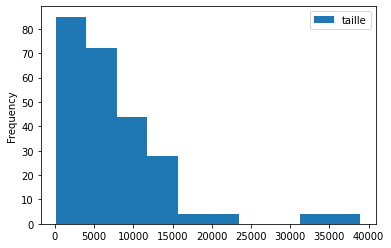

In [ ]:
donnees.plot.hist(bins=10)

## suppression des doublons
> affectation sur taille DNS la plus courte

In [ ]:
temp = donnees [donnees ['taille']>30000]

In [ ]:
index2 = []
DejaVus = []

In [ ]:
for url in index:
  if url not in DejaVus:
    tempo = [url2 for url2 in soupe.keys() if soupe [url2] == soupe [url]]
    DejaVus .extend(tempo)
    zoneDnsMini = min([len(url) for url in tempo])
    index2.append([url3 for url3 in tempo if len(url3) == zoneDnsMini][0])


In [ ]:
Parts = donnees .loc[index2]

In [ ]:
Parts

# Nouvelles stats

In [ ]:
index = list([url for url in index2 if url not in aVirer and url in aGarder])

data  = [len(soupe[url]) for url in index2 ]
donnees = pd.DataFrame.from_dict(data)
donnees.index = index
donnees.columns=["taille"]
stats  = donnees.describe()

In [ ]:
stats

,taille
count,82.000000
mean,7543.634146
std,6306.432952
min,152.000000
25%,3669.750000
50%,6171.500000
75%,10566.500000
max,38948.000000


In [ ]:
tempo = donnees ['taille'] .value_counts() 

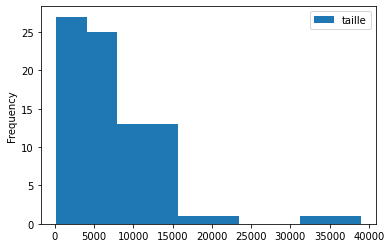

In [ ]:
donnees.plot.hist(bins=10)

In [ ]:
donnees2 = donnees [donnees ['taille']>500]

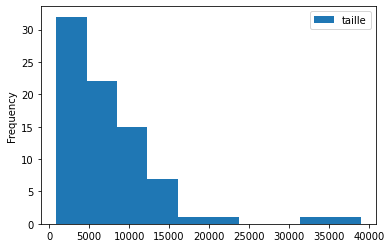

In [ ]:
donnees2.plot.hist(bins=10)

In [ ]:
supprimés = donnees [donnees ['taille']<=500]

In [ ]:
index = list([url for url in donnees2 .index if url not in aVirer and url in aGarder])

data  = [len(soupe[url]) for url in index ]
donnees = pd.DataFrame.from_dict(data)
donnees.index = index
donnees.columns=["taille"]
stats  = donnees.describe()

In [ ]:
stats

In [ ]:
Partners = dict()
for url in soupe.keys():
  if url in index:
    Partners [url] = soupe [url]

In [ ]:
fichierDeSortie = stockageSortie + "/OUT/ContenusSites/PartnersNettoyes.pkl"
with open (fichierDeSortie, 'wb') as  fictemp: #on met tous les contenus dans pickle
  pickle.dump(Partners, fictemp)


In [ ]:
fichierDeSortie = stockageSortie + "/OUT/ContenusSites/stats.pkl"

In [ ]:
with open (fichierDeSortie, 'wb') as  fictemp: #on met tous les contenus dans pickle
  pickle.dump(donnees, fictemp)



---



# Traitement des fichiers produits par le scrapper
> ndf est le fichier produit par le scapper. On le charge le spacytraite pour visualiser

In [ ]:
dicoEtiquettage = dict()
aEviter = dict()
verbes = dict() #listes à remplir avec verbes/adj/noms/entités trouvés 
adjectifs  = dict() 
noms = dict()

adverbes = dict()


In [ ]:
  tal = spacy.load('fr_core_news_sm')
    # 'fr_dep_news_trf' fonctionne mieux pour le reste
  tal1 = spacy.load('fr_dep_news_trf', disable = ['tagger', 'parser', 'textcat'])

In [ ]:
dicoEtiquettage, aEviter, catGramm = dict(), dict(), dict()

In [ ]:
for url in Partners.keys():
  doc = tal (Partners [url])
  dicoEtiquettage[url] = dict()

  entites = []
  for entity in doc.ents:
    if entity.label_ not in dicoEtiquettage[url].keys():
        dicoEtiquettage[url][entity.label_] = []
        dicoEtiquettage[url][entity.label_].append(entity.text)
        entites.append(entity.label_)
    else:
        dicoEtiquettage[url][entity.label_].append(entity.text)
      #entites.append(entity.text)
      #dicoEtiquettage [url] [entity.label_] = entites #dico: [étiquettage de entité donné par spacy] = la liste des entités
  if url not in aEviter.keys():
      aEviter[url] = []
  if 'LOC' in dicoEtiquettage[url].keys():
      aEviter[url] += dicoEtiquettage[url]['LOC']
  if 'MISC' in dicoEtiquettage [url].keys():
      aEviter[url] += dicoEtiquettage[url]['MISC']
  if 'PER' in dicoEtiquettage [url].keys():
      aEviter[url] += dicoEtiquettage [url]['PER']
  if 'ORG' in dicoEtiquettage [url].keys():
      aEviter[url] += dicoEtiquettage[url]['ORG']


  # utilisation de l'autre modèle
  doc = tal1(Partners [url].lower())

  if url not in verbes.keys():
        verbes[url] = []
  if url not in adjectifs.keys():
        adjectifs[url] = []
  if url not in noms.keys():
        noms[url] = []
  if url not in adverbes.keys(): #ADVERBES
        adverbes[url] = []
  for truc in doc: 
    if truc.text not in aEviter[url] and truc.text.lower() not in aEviter[url]: 
      if len(truc.text)>2:

            if truc.pos_ == "VERB":
              verbes[url].append(truc.lemma_) #ajoute à la liste (.lemma_ fait la lemmatisation)
              dicoEtiquettage[url][truc.pos_] = verbes[url] #ajoute dans le dico: ["VERB"] = la liste des verbes
            if truc.pos_ == "ADJ":
              adjectifs[url].append(truc.lemma_) 
              dicoEtiquettage [url][truc.pos_] = adjectifs[url] #dico:["ADJ"] = la liste des adjectifs
            if truc.pos_ == "NOUN":
              noms[url].append(truc.lemma_)
              dicoEtiquettage[url][truc.pos_] = noms[url] #dico: ["NOUN"] = la liste des noms  
            
            if truc.pos_ == "ADV": 
              adverbes[url].append(truc.lemma_)
              dicoEtiquettage[url][truc.pos_] = adverbes[url] #dico: ["ADV"] = la liste des adverbes
  catGramm [url] = dict()

  for cle in dicoEtiquettage[url]: 
    catGramm [url][cle] = Counter(dicoEtiquettage[url][cle])
 
    

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
print(catGramm[url])

{'LOC': Counter({'Porquerolles': 11, 'Accueil': 1, 'Ile de Porquerolles': 1, 'Parc national': 1, 'Découvrez': 1, 'Mentions': 1}), 'MISC': Counter({'COPAINS    ': 1, 'Espaces naturels': 1, 'Nos produits bio   ': 1, 'Particuliers  ': 1, 'COPAINS': 1}), 'PER': Counter({'Porquerollais  Conditions de Livraison    ': 1, 'Sélectionner': 1, 'Solidaire': 1, 'Adopter': 1}), 'ORG': Counter({'TTC': 8, 'Article': 1, 'Forêts Varoises Sauvegarde': 1, 'Forêts Varoises': 1, 'Une Economie Sociale': 1}), 'NOUN': Counter({'ttc': 8, 'produit': 5, 'service': 4, 'espace': 4, 'emploi': 4, 'min': 4, 'sauvegarde': 3, 'projet': 3, 'partenaire': 3, 'environnement': 3, 'préservation': 3, 'caviar': 3, 'aubergine': 3, 'copain': 2, 'propreté': 2, 'nettoyage': 2, 'plage': 2, 'agenda': 2, 'forêt': 2, 'développement': 2, 'territoire': 2, 'mûrier': 2, 'entretien': 2, 'point': 2, 'vente': 2, 'chutney': 2, 'figue': 2, 'accueil': 1, 'foret': 1, 'propos': 1, 'panier': 1, 'condition': 1, 'livraison': 1, 'particulier': 1, 'ent

In [ ]:
fichierDeSortie = stockageSortie + "/OUT/ContenusTraites/Partners.pkl"
with open (fichierDeSortie, 'wb') as  fictemp: #on met tous les contenus dans pickle
  pickle.dump(dicoEtiquettage, fictemp)

# Les partenaires

> Les partenaires sont les sites cités par le site d'origine, citant eux-même le site. Les motivations de citation étant aussi variées que les motivations de partenariat nous tentons de regrouper ces partenaires selon les catégories identifiées.

Les sites des partenaires ont été identifiés par le logiciel Hyphe (Médialab)

Note: si l'url n'a pas été collecté dans la phase d'initialisation (scrapping) alors son champ lexical n'est pas utilisé

# Sauvegarde des traitements

In [ ]:
fichierDeSortie = stockageSortie + '/OUT/ContenusTraites/' +"verbesSitesPartners.pkl"
with open (fichierDeSortie, 'wb') as  fictemp: #on met tous les contenus dans pickle
  pickle.dump(verbes, fictemp)

fichierDeSortie = stockageSortie + '/OUT/ContenusTraites/' +'nomsSitesPartners.pkl'
with open (fichierDeSortie, 'wb') as  fictemp: #on met tous les contenus dans pickle
  pickle.dump(noms, fictemp)

fichierDeSortie = stockageSortie + '/OUT/ContenusTraites/' +'adjectifsSitesPartners.pkl'
with open (fichierDeSortie, 'wb') as  fictemp: #on met tous les contenus dans pickle
  pickle.dump(adjectifs, fictemp)

fichierDeSortie = stockageSortie + '/OUT/ContenusTraites/' +'adverbesSitesPartners.pkl'
with open (fichierDeSortie, 'wb') as  fictemp: #on met tous les contenus dans pickle
  pickle.dump(adverbes, fictemp)

In [ ]:
import json
fichierDeSortie = stockageSortie + 'OUT/JSON/' +'ContenusPartners.json'
with open(fichierDeSortie, 'w', encoding='utf-8') as f:
    json.dump(dicoEtiquettage,f )
fichierDeSortie = stockageSortie + 'OUT/JSON/' +'ListePartners.json'
with open(fichierDeSortie, 'w', encoding='utf-8') as f:
    json.dump(list(dicoEtiquettage .keys()),f )
    

In [ ]:
dicoEtiquettagePartners.keys()

dict_keys(['Hebergement', 'organisations', 'oTourism', 'Gouv', 'locations', 'mairies', 'restauration', 'parcs', 'Services'])

# Tests des représentations

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
from urllib import parse


def makeImage(text):
    wc = WordCloud(background_color="white", max_words=100,width=800, height=400)
    wc.generate_from_frequencies(text)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [ ]:
catGramm .keys()

dict_keys(['http://fr-fr.facebook.com/pages', 'https://fr-fr.facebook.com/pages', 'http://alizee-soft.com', 'http://pyrenees-parcnational.fr', 'http://guadeloupe-parcnational.fr', 'http://calanques-parcnational.fr', 'http://ecrins-parcnational.fr', 'http://colleo.fr', 'http://cevennes-parcnational.fr', 'http://espritparcnationalportcros.com', 'https://espritparcnationalportcros.com', 'http://forets-parcnational.fr', 'http://ofb.gouv.fr', 'http://parcsnationaux.fr', 'http://portcrosparcnational.fr', 'http://mercantour.eu', 'http://reunion-parcnational.fr', 'http://parc-amazonien-guyane.fr', 'http://www.var.gouv.fr', 'http://vanoise-parcnational.fr', 'http://www.vanoise-parcnational.fr', 'https://vanoise-parcnational.fr', 'https://www.vanoise-parcnational.fr', 'http://espritparcnational.com', 'http://ac-nice.fr', 'http://premar-mediterranee.gouv.fr', 'http://hyeres-tourisme.com', 'http://festival-galathea.com', 'http://tlv-tvm.com', 'http://bateauxverts.com', 'http://www.bateauxverts.com

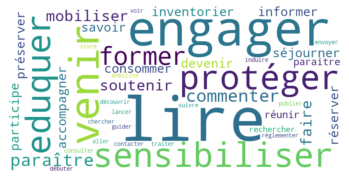

In [ ]:
makeImage(catGramm["http://portcrosparcnational.fr"] ['VERB'])

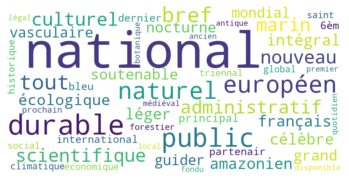

In [ ]:
makeImage(catGramm["http://portcrosparcnational.fr"] ['ADJ'])

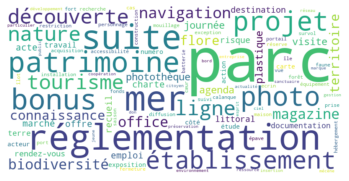

In [ ]:
makeImage(catGramm["http://portcrosparcnational.fr"] ['NOUN'])